<a href="https://colab.research.google.com/github/create-with-pritam/GAN-on-Cifar-10-/blob/main/cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


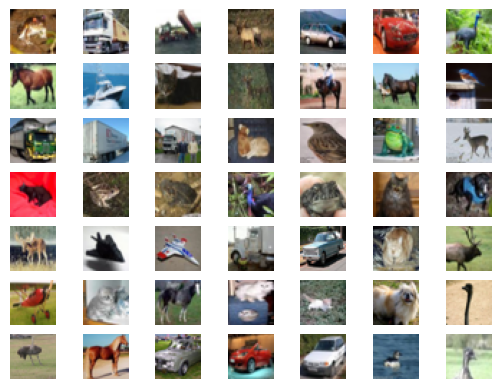

In [ ]:
#example of loading and plotting he cifar 10 dataset
from keras.datasets.cifar10  import load_data
from matplotlib import pyplot
#load dataset
(trainX, trainy), (testX, testy) = load_data()
#plot images from the training dataset
for i in range(49):
  pyplot.subplot(7,7,1+i)
  pyplot.axis('off')
  pyplot.imshow(trainX[i])
pyplot.show()

In [ ]:
print(trainX.shape)

(50000, 32, 32, 3)


In [ ]:
#examples of defining the discriminator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import numpy as np

In [ ]:
#define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  #model
  model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(negative_slope=0.2))
  #downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(negative_slope=0.2))
  #downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(negative_slope=0.2))
  #downsample
  model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(negative_slope=0.2))
  #classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  #compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
#Function to load datset and scale it
#load and prepare cifar10 training images
def load_real_samples():
  (trainX, _), (_, _) = load_data()
  #convert from unsigned integers to floats
  X=trainX.astype('float32')
  #scale from [0,255] to [0,1]
  X=(X-127.5)/127.5
  return X

In [ ]:
X=load_real_samples()
X.shape
X[0]

array([[[-0.5372549 , -0.5137255 , -0.5058824 ],
        [-0.6627451 , -0.6392157 , -0.64705884],
        [-0.60784316, -0.62352943, -0.6627451 ],
        ...,
        [ 0.23921569,  0.03529412, -0.15294118],
        [ 0.19215687, -0.01960784, -0.2       ],
        [ 0.16078432, -0.02745098, -0.19215687]],

       [[-0.8745098 , -0.84313726, -0.84313726],
        [-1.        , -1.        , -1.        ],
        [-0.85882354, -0.9372549 , -1.        ],
        ...,
        [-0.03529412, -0.30980393, -0.5686275 ],
        [-0.06666667, -0.34901962, -0.60784316],
        [-0.04313726, -0.31764707, -0.5529412 ]],

       [[-0.8039216 , -0.8117647 , -0.8352941 ],
        [-0.8745098 , -0.94509804, -1.        ],
        [-0.6156863 , -0.7882353 , -0.9372549 ],
        ...,
        [-0.07450981, -0.34117648, -0.60784316],
        [-0.05882353, -0.34117648, -0.60784316],
        [-0.14509805, -0.42745098, -0.67058825]],

       ...,

       [[ 0.6313726 ,  0.33333334, -0.24705882],
        [ 0

In [ ]:
#select real images
def generate_real_samples(dataset, n_samples):
  #choose random instances
  X = np.random.rand(32 * 32 * 3 * n_samples)
  #upgrate to have the range [-1,1]
  X=-1+X*2
  #reshape into a batch of colour images
  X=X.reshape((n_samples, 32, 32, 3))
  #generate fake class labels(0)
  y=np.ones((n_samples, 1))
  return X, y

In [ ]:
X,y= generate_real_samples(X, 64)
print(X.shape, y.shape)
print(y)

(64, 32, 32, 3) (64, 1)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [ ]:
#generate a fake samples with class labels
def generate_fake_samples(n_samples):
  #generate uniformm random numbers in [0,1]
  X=np.random.rand(32*32*3*n_samples)
  #upgrate to have the range [-1,1]
  X=-1+X*2
  #reshape into a batch of colour images
  X=X.reshape((n_samples, 32, 32, 3))
  #generate fake class labels(0)
  y=np.zeros((n_samples, 1))
  return X, y

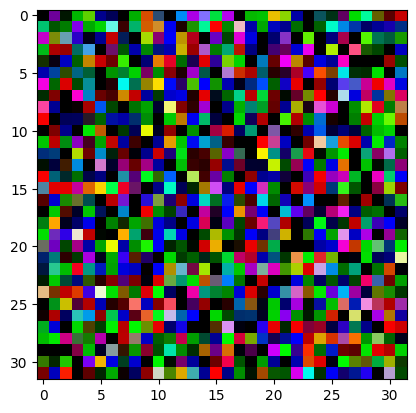

In [ ]:
X,y= generate_fake_samples( 64)
pyplot.imshow(X[0])

In [ ]:
#Train the discriminator model temporarily
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
  half_batch=int(n_batch/2)
  #manually enumerate epochs
  for i in range(n_iter):
    #get randomly selected real samples
    X_real, y_real=generate_real_samples(dataset, half_batch)
    #update discriminator on real images
    _, real_acc=model.train_on_batch(X_real, y_real)
    #generate fake samples
    X_fake, y_fake=generate_fake_samples(half_batch)
    #update discriminator on fake images
    _, fake_acc=model.train_on_batch(X_fake, y_fake)
    #summarize performance
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
#example Training

#define the discriminator model
model=define_discriminator()
#load image data
dataset=load_real_samples()
#train model
train_discriminator(model, dataset)

>1 real=61% fake=30%
>2 real=53% fake=39%
>3 real=51% fake=42%
>4 real=50% fake=44%
>5 real=49% fake=45%
>6 real=49% fake=45%
>7 real=48% fake=45%
>8 real=48% fake=45%
>9 real=48% fake=46%
>10 real=48% fake=46%
>11 real=48% fake=46%
>12 real=47% fake=46%
>13 real=47% fake=46%
>14 real=47% fake=46%
>15 real=47% fake=45%
>16 real=46% fake=45%
>17 real=46% fake=45%
>18 real=46% fake=45%
>19 real=46% fake=45%
>20 real=46% fake=45%


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
#define the standalone generator model
def define_generator(latent_dim):
  model=Sequential()
  #foundation for 4*4 image
  n_nodes=256*4*4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))
  #upsample to 8*8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #upsample to 16* 16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #upsample to 32*32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #output layer
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 4096)                │         413,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 3)           │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,466,115 (5.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 0 (0.00 B)

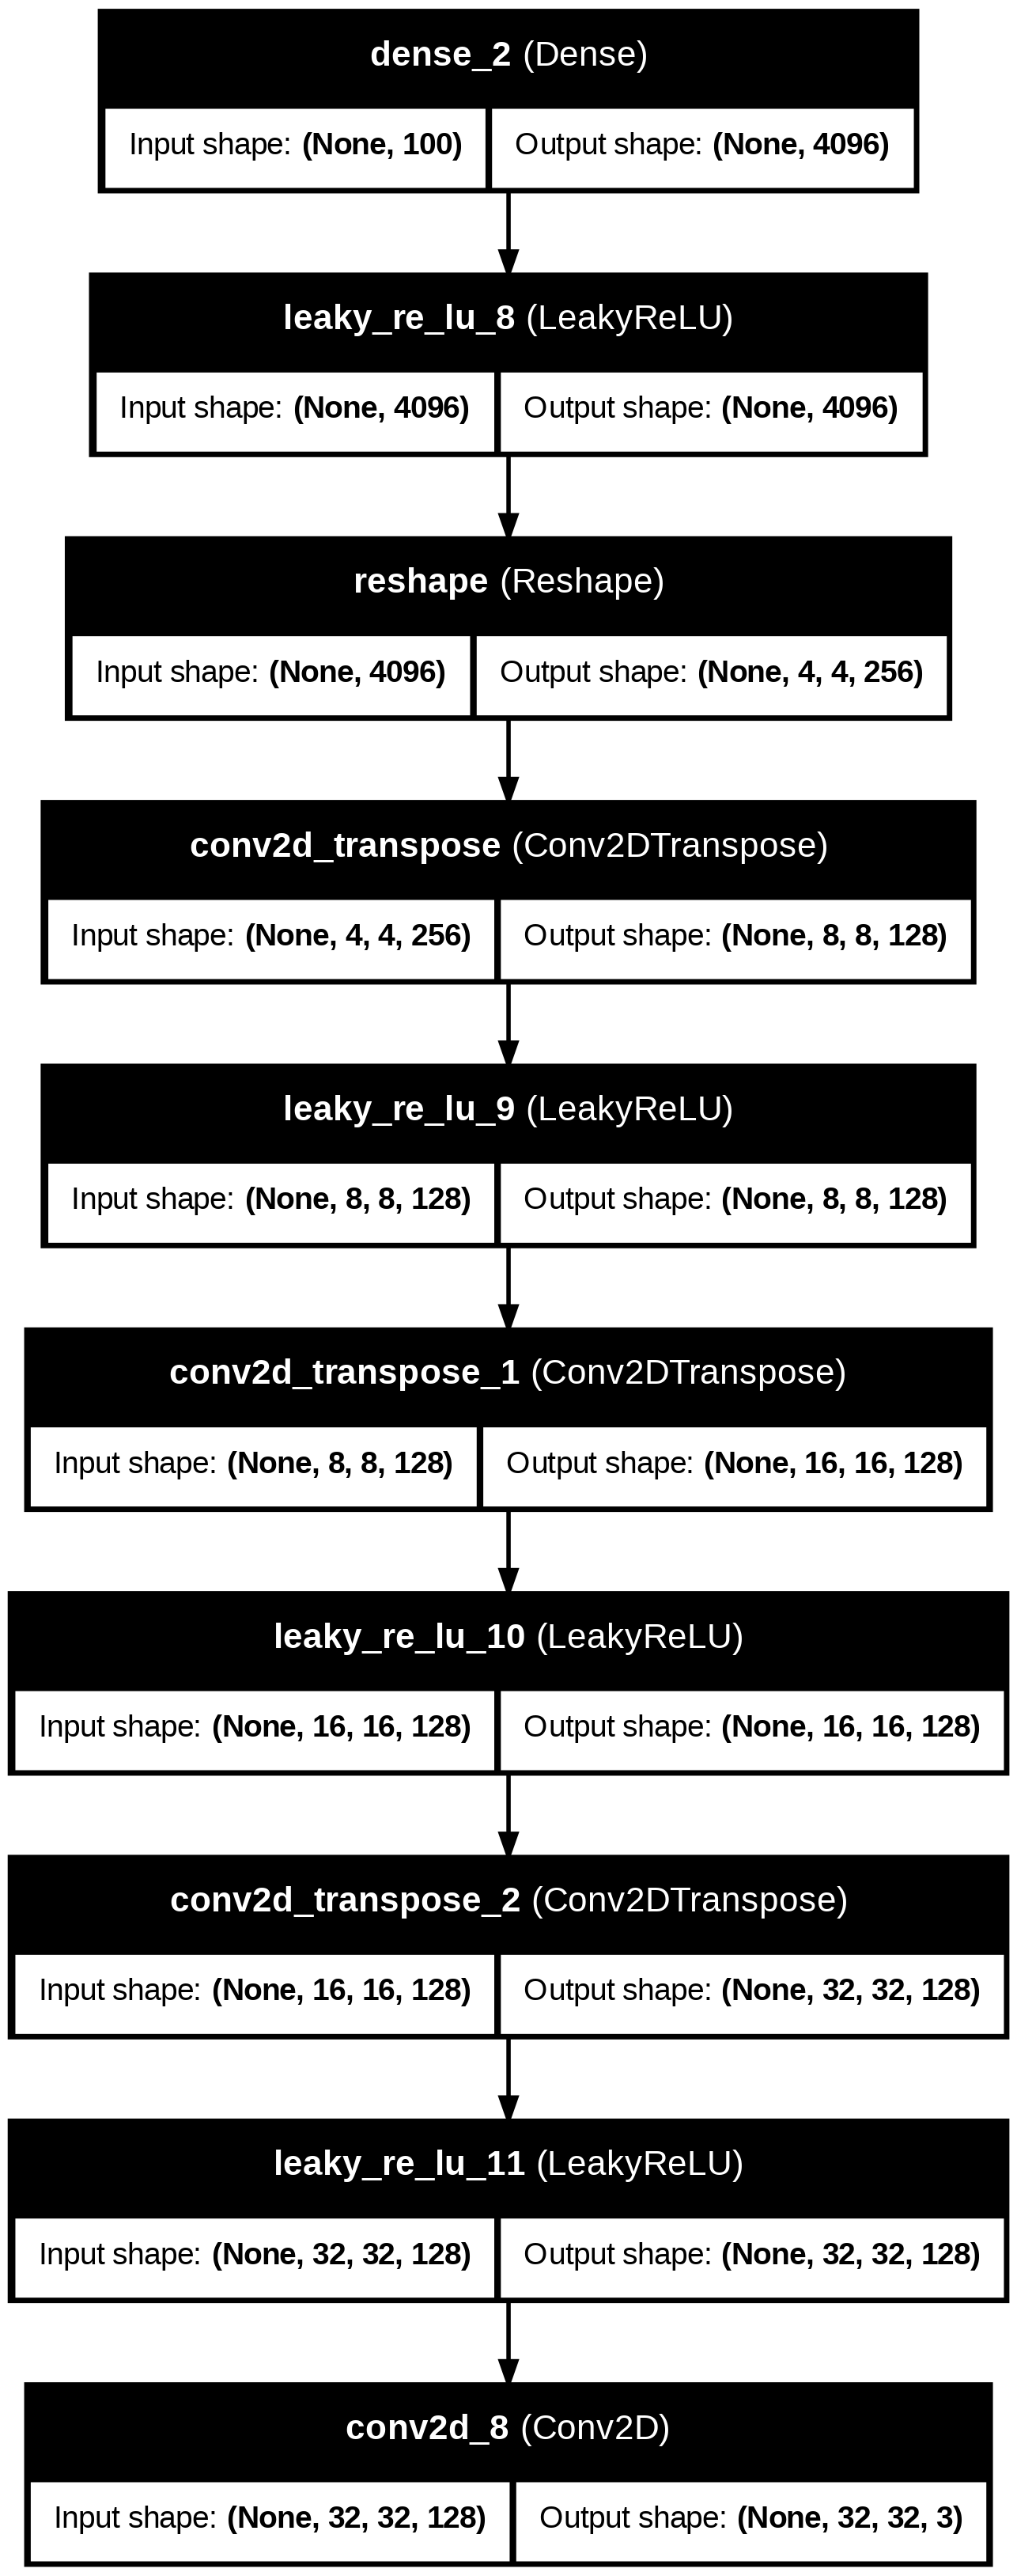

In [ ]:
#define the size of the latent space
latent_dim=100
#create the generator
model=define_generator(latent_dim)
#summarize the model
model.summary()
#plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  #generate points in the latent space
  x_input=np.random.randn(latent_dim*n_samples)
  #reshape into a batch of inputs for the network
  x_input=x_input.reshape(n_samples, latent_dim)
  return x_input

In [ ]:
#use the generator to generate n fake examples, with  class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  #generate points in latent space
  x_input=generate_latent_points(latent_dim, n_samples)
  #predict outputs
  X=g_model.predict(x_input)
  #create 'fake' class labels(0)
  y=np.zeros((n_samples, 1))
  return X, y

In [ ]:
x_input=generate_latent_points(100, 64)
print(x_input.shape)

(64, 100)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step


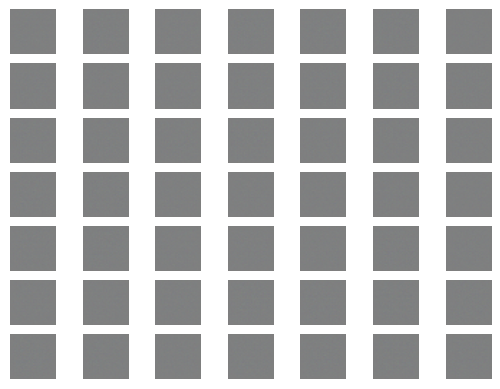

In [ ]:
#size of the latent space
latent_dim=100
#define the discriminator model
model = define_generator(latent_dim)
#generate sampless
n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)
#scale pixel values from [-1,1] to [0,1]
X = (X+1)/2.0
#plot the generated samples
for i in range(n_samples):
  #define subplot
  pyplot.subplot(7,7,1+i)
  #turn off axis labels
  pyplot.axis('off')
  #plot single image
  pyplot.imshow(X[i])
pyplot.show()

In [ ]:
#define combined generator and discriminator model, for updating the model
def define_gan(g_model, d_model):
  #make weights in discrimiunator not trainable
  d_model.trainable = False
  #connect them
  model = Sequential()
  #add generator
  model.add(g_model)
  #add the discriminator
  model.add(d_model)
  #compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)            │ (None, 32, 32, 3)           │       1,466,115 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 1)                   │         522,497 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,988,612 (7.59 MB)

 Trainable params: 1,466,115 (5.59 MB)

 Non-trainable params: 522,497 (1.99 MB)

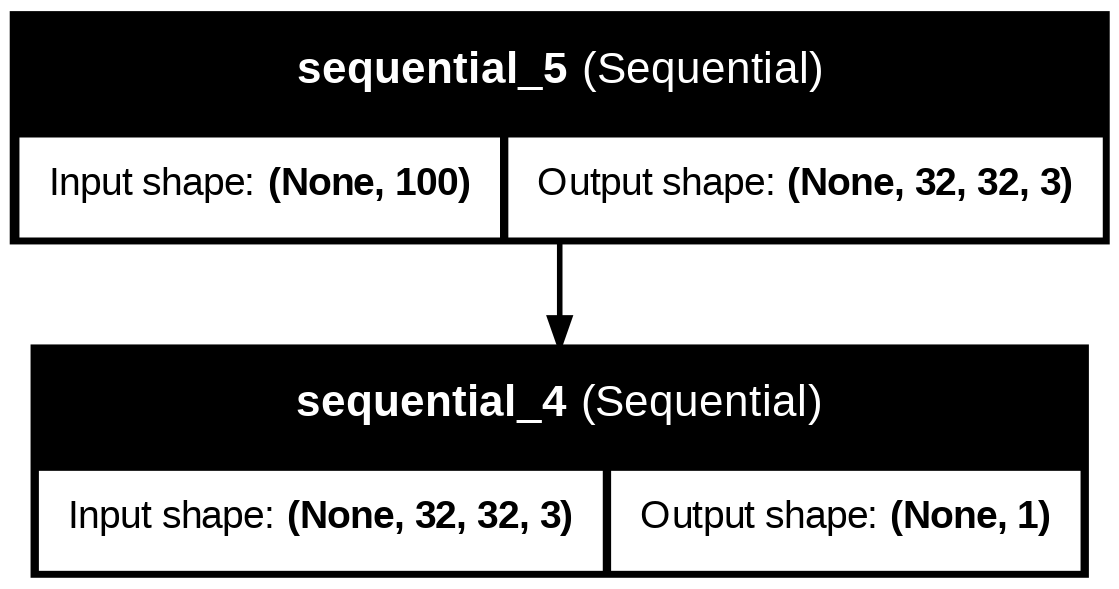

In [ ]:
#size  of the latent space
latent_dim=100
#create the discriminator
d_model=define_discriminator()
#create the generator
g_model=define_generator(latent_dim)
#create the gan
gan_model=define_gan(g_model, d_model)
#summarize the gan model
gan_model.summary()
#plot the model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
#training the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo=int(dataset.shape[0]/n_batch)
  half_batch=int(n_batch/2)
  #manually enumerate epochs
  for i in range(n_epochs):
    #enumerate batches over the training set
    for j in range(bat_per_epo):
      #get randomly selected "real" samples

SyntaxError: incomplete input (<ipython-input-24-be4aa615c937>, line 9)